# Understanding the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import string
import cv2
import json
import pickle
import collections
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add


In [2]:
def readTxtFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
# read from the input that contains captions of each image
captions = readTxtFile("../input/flickr8k/captions.txt")

In [4]:
captions = captions.split('\n')[1:-1] #rejecting the first and last row as it is redundant

In [5]:
print(len(captions))
print(captions[0])
print(captions[1])
print(captions[2])
captions[0].split(".jpg,")

40455
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


['1000268201_693b08cb0e',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [6]:
# dictionary to map image ids with their respective captions
descriptions = {}

for x in captions:
    img_name, img_desc = x.split(".jpg,")
    # if the img_name is not present
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(img_desc)

In [7]:
# checking if we got our dictionary correctly
# we have 5 captions for each image in the dataset
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

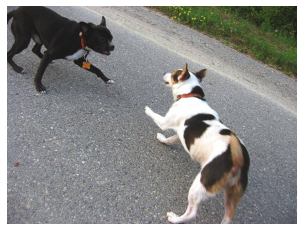

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [8]:
IMG_PATH = "../input/flickr8k/Images/"

def readImg(imgId):
    img = cv2.imread(IMG_PATH + imgId + ".jpg")# checking our image with a id
    # since cv2 reads our image in bgr format, we convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    #plt.title(descriptions[imgId][0])
    plt.show()
readImg("1001773457_577c3a7d70")
descriptions["1001773457_577c3a7d70"]

**Key points from the data set:**
* Has /Images folder with 8000 images
* Has a captions.txt file which has 5 captions for each image
* The captions are mapped with the image id

# Data Cleaning

In [9]:
def clean(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence) # substitute that is not an alphabet replace with space
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1] # reject all words of length 1
    sentence = " ".join(sentence)
    return sentence

In [10]:
# iterate over all (key, value) pairs
for key,caption in descriptions.items():
    # iterate over all captions i.e. 5
    for i in range(len(caption)):
        # clean ith caption
        caption[i] = clean(caption[i])

In [11]:
descriptions["1001773457_577c3a7d70"]

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [12]:
# save our newly made dictionary after cleaning
# so that we can save time for large datasets
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

# Vocabulary
Set of unique words model can predict, i.e. trace back our probability output number to map from the vocab

In [13]:
# using json.load() to read the dictionary into python
descriptions = None
with open("descriptions.txt") as f:
    descriptions = f.read()
json_str = descriptions.replace("'", "\"")
descriptions = json.loads(json_str)

In [14]:
print(type(descriptions))

<class 'dict'>


In [15]:
vocab = set()
for key in descriptions.keys():
    # for each sentence we split it into words and pass it to set vocab from descriptions dictionary
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [16]:
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Word %d"%len(total_words))

Total Word 373803


In [17]:
counter = collections.Counter(total_words)
freq_count = dict(counter)

In [18]:
# sort our frequency count based on value
sorted_freq_count = sorted(freq_count.items(), reverse=True, key=lambda x : x[1])
threshold_freq = 10
# we reject all the words whose frequency is less than 10
sorted_freq_count = [x for x in sorted_freq_count if x[1] > threshold_freq]
total_words = [x[0] for x in sorted_freq_count]

In [19]:
print(len(total_words)) # final vocab size

1845


# Preparing Training Data

In [20]:
data = []
for k in descriptions.keys():
    data.append(k)
print(len(data))

8091


In [21]:
splitSize = int(0.8 * len(data)) # 80-20 partition for training and test data
train_data = data[ : splitSize]
test_data = data[splitSize : ]
print(len(train_data), len(test_data))

6472 1619


In [22]:
# Add <start> and <end> token to our training data
# this determines where to start and where to stop
train_descriptions = {}
for img_id in train_data:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_ = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_)

In [23]:
train_descriptions["1001773457_577c3a7d70"]
# each sentence has 'startseq' and 'endseq'

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Transfer Learning 
To extract features from images and text

## Features from Images

In [24]:
# using pretrained model RESNET50
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

2022-09-05 20:27:22.087228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 20:27:22.211630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 20:27:22.212568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 20:27:22.214122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [25]:
model.layers[-2]

In [26]:
# we want to create a use the CONV model but upto the global average pooling layer
model_new = Model(model.input, model.layers[-2].output)

In [27]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0) # [Batchsize, 224, 224, 3] extend 3d tensor to 4d
    # Normalisation
    img = preprocess_input(img)
    return img

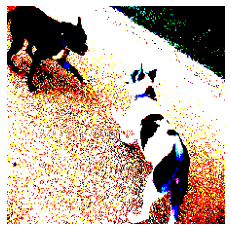

In [28]:
img = preprocess_img(IMG_PATH+"1001773457_577c3a7d70.jpg")
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [29]:
def encode_img(img):
    img = preprocess_img(img) # preprocess the image and normalize it
    feature_vector = model_new.predict(img) # passing through resnet conv layers
    # print(feature_vector.shape) # (1, 2048)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [30]:
encode_img(IMG_PATH+"1001773457_577c3a7d70.jpg")

2022-09-05 20:27:27.585345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-05 20:27:29.253071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


array([0.78418046, 0.8189698 , 0.06491414, ..., 0.08858453, 0.68538064,
       0.18749654], dtype=float32)

In [31]:
from time import time
encoding_train = {}
# img_id -> feature_vector
start_t = time()
for i, img_id in enumerate(train_data):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if i%100==0:
        print("Encoding Progress %d"%i)
end_t = time()
print("Total Time Taken :", end_t-start_t)

Encoding Progress 0
Encoding Progress 100
Encoding Progress 200
Encoding Progress 300
Encoding Progress 400
Encoding Progress 500
Encoding Progress 600
Encoding Progress 700
Encoding Progress 800
Encoding Progress 900
Encoding Progress 1000
Encoding Progress 1100
Encoding Progress 1200
Encoding Progress 1300
Encoding Progress 1400
Encoding Progress 1500
Encoding Progress 1600
Encoding Progress 1700
Encoding Progress 1800
Encoding Progress 1900
Encoding Progress 2000
Encoding Progress 2100
Encoding Progress 2200
Encoding Progress 2300
Encoding Progress 2400
Encoding Progress 2500
Encoding Progress 2600
Encoding Progress 2700
Encoding Progress 2800
Encoding Progress 2900
Encoding Progress 3000
Encoding Progress 3100
Encoding Progress 3200
Encoding Progress 3300
Encoding Progress 3400
Encoding Progress 3500
Encoding Progress 3600
Encoding Progress 3700
Encoding Progress 3800
Encoding Progress 3900
Encoding Progress 4000
Encoding Progress 4100
Encoding Progress 4200
Encoding Progress 4300


In [32]:
# store the trained data from the resnet locally
encoding_train["1001773457_577c3a7d70"]

array([0.78418046, 0.8189698 , 0.06491414, ..., 0.08858453, 0.68538064,
       0.18749654], dtype=float32)

In [33]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train, f)

In [34]:
encoding_test = {}
# img_id -> feature_vector
start_t = time()
for i, img_id in enumerate(test_data):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if i%100==0:
        print("Encoding Progress %d"%i)
end_t = time()
print("Total Time Taken :", end_t-start_t)

Encoding Progress 0
Encoding Progress 100
Encoding Progress 200
Encoding Progress 300
Encoding Progress 400
Encoding Progress 500
Encoding Progress 600
Encoding Progress 700
Encoding Progress 800
Encoding Progress 900
Encoding Progress 1000
Encoding Progress 1100
Encoding Progress 1200
Encoding Progress 1300
Encoding Progress 1400
Encoding Progress 1500
Encoding Progress 1600
Total Time Taken : 92.02601671218872


In [35]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

# Preprocessing Captions

In [36]:
# vocab
len(total_words)

1845

In [37]:
word_to_index = {}
index_to_word = {}
for i, word in enumerate(total_words):
    word_to_index[word] = i+1;
    index_to_word[i+1] = word 

In [38]:
print(word_to_index["on"], index_to_word[7])

3 with


In [39]:
index_to_word[1846] = "startseq"
word_to_index["startseq"] = 1846

index_to_word[1847] = "endseq"
word_to_index["endseq"] = 1847

vocab_size = len(word_to_index) + 1
print(vocab_size)

1848


In [40]:
pickle
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
print(max_len)

35


# Supervised Learning Problem
Language Modelling: 
Probabilities of getting a output depends on all the previous outputs
P(W_t+1 | W1.....Wt)


In [41]:
# data generator
def data_generator(train_descriptions, encoding_train, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], [] #image vector X1, partial vector X2, target word y
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for capt in desc_list:
                seq = [word_to_index[word] for word in capt.split() if word in word_to_index]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # zero padding
                    # returns a 2d matrix
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n == batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    X1, X2, y = [], [], []
                    n = 0

# Word Embeddings

In [42]:
# transfer learning on text
f = open("../input/glove6b50dtxt/glove.6B.50d.txt")

In [43]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
f.close()

In [44]:
embedding_index['boy']

array([-0.32345 ,  0.23332 , -0.20082 , -0.52848 ,  1.0926  ,  0.62445 ,
       -0.99859 ,  0.28085 ,  0.088326,  0.36919 ,  0.32199 ,  0.3499  ,
        0.067459,  0.24211 ,  0.92565 , -0.32581 , -0.99134 ,  0.80767 ,
       -0.22845 ,  0.40076 , -0.8577  ,  1.3836  ,  0.056439,  0.76561 ,
        0.3608  , -2.0692  , -0.46679 ,  0.12359 ,  0.35127 , -0.77092 ,
        2.2064  , -0.42605 , -0.24279 ,  0.3832  ,  0.6069  ,  0.62835 ,
        0.31825 , -0.8851  ,  0.38329 , -1.146   , -0.41949 ,  0.2606  ,
       -0.6568  , -0.11511 ,  1.0591  , -0.61148 ,  0.32152 , -1.3182  ,
        0.31744 ,  0.02527 ])

In [45]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [46]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

# Model Architecture

image features and partial sequence ----> |model| ---->  next word in seq


In [47]:
# output of resnet50 is feed in this
input_img_features = Input(shape=(2048,))
input_img1 = Dropout(0.3)(input_img_features)
input_img = Dense(256, activation='relu')(input_img1)


In [48]:
input_captions = Input(shape=(max_len, ))
input_cap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero=True)(input_captions)
input_cap2 = Dropout(0.3)(input_cap1)
input_cap = LSTM(256)(input_cap2) # output size 256

In [49]:
decoder1 = add([input_img, input_cap])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [50]:
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [52]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False # pre trained using transfer learning

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training Model

In [54]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_index, max_len, batch_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


   5/2157 [..............................] - ETA: 31s - loss: 3.5264

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2157/2157 [==============================] - 28s 13ms/step - loss: 2.5912


# Predictions

In [55]:
model = load_model('./model_weights/model_6.h5')

In [56]:
def predict_caption(photo):
    text = "startseq"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        yPred = model.predict([photo, sequence])
        yPred = yPred.argmax()
        word = index_to_word[yPred]
        text += (' '+ word)
        if word == 'endseq':
            break
    
    final_caption = text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

group of people are playing with their hands in the air
group of men with shovels are digging in salt


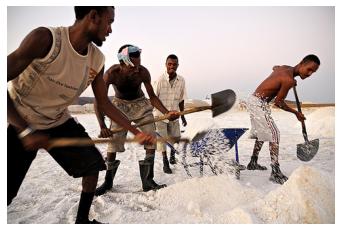

man in black shirt is skateboarding down ramp
man is sitting on bench behind bike


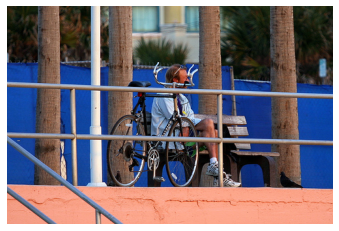

dog is running through water
black dog has just jumped into swimming pool


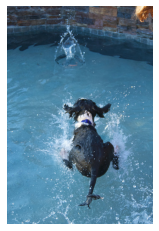

man in helmet is riding bike on dirt track
biker makes high jump


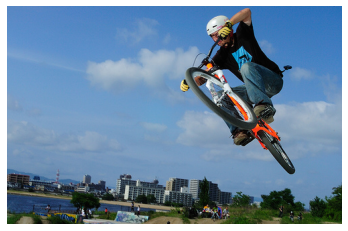

two people are playing in the sand
three girls do back flips and cartwheels in the surf


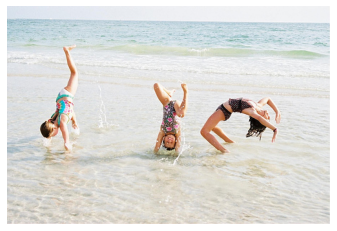

man in green shirt is jumping off rock into the air
mountain biker does trick on forest path


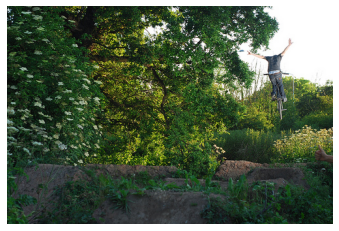

blue and white bird is flying through the air
bee clings to yellow flower


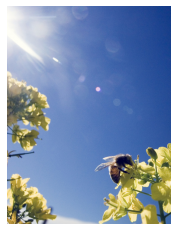

two children are playing in pool
girl flipping into swimming pool while others swim


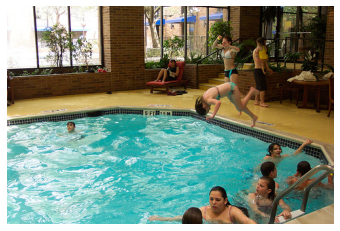

man and woman are standing on cliff overlooking the ocean
hiker posing on cliff high in the mountains


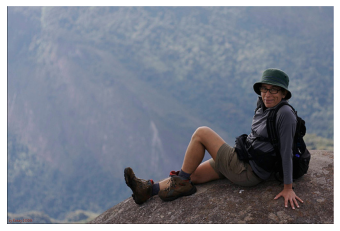

man in red shirt is standing on the ground near the of plants
female jogger wearing red


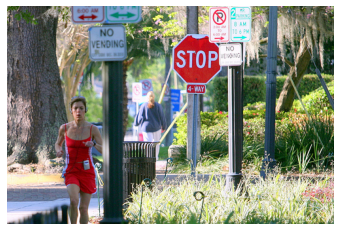

man in black shirt is standing on the grass with his dog
guy walking his four dogs


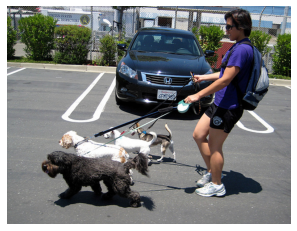

two dogs run through the snow
one dog is standing whilst two other dogs are running in the snow


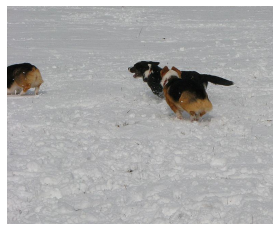

group of people are posing for picture
girl with black dress and big white bow stands with her back to the camera


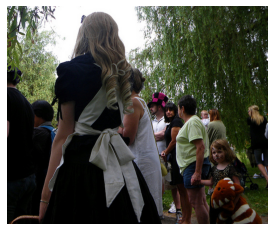

two dogs run through field
brown and white dog is jumping high and catching blue ball


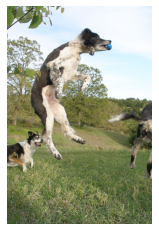

man in red shirt is standing on the street
these woman are watching people play tennis from bench


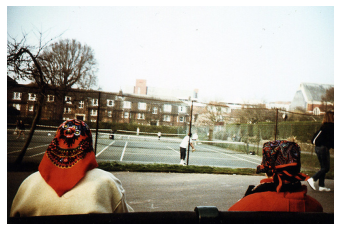

In [57]:
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img = list(encoding_test.keys())
    img_name = all_img[idx]
    photo = encoding_test[img_name].reshape((1,2048))
    lol = plt.imread(IMG_PATH+img_name+'.jpg')
    caption = predict_caption(photo)
    print(caption)
    print(descriptions[img_name][0])
    plt.imshow(lol)
    plt.axis('off')
    plt.show()
    